## Modelltraining auf bereinigtem BSR-Datensatz

In [46]:
import pandas as pd
import os

file_path = os.path.join( "..", "Daten",  "BSR_data_for_training.csv")

df = pd.read_csv(file_path) 
df.head(3)

,Monat,KW,Jahr,Schicht,Tour,Tonnage,Abfallart_BIO,Abfallart_HM,Abfallart_SPM Sammlung,Tag,Hof_VMF,Hof_VMG,Hof_VMM,Hof_VMN,Hof_VMWSF,Hof_VMWSM,Hof_VMWSN
0,1,1,2019,1,1,5.59,1,0,0,2,1,0,0,0,0,0,0
1,1,1,2019,1,4,3.23,1,0,0,2,1,0,0,0,0,0,0
2,1,1,2019,1,5,5.68,1,0,0,2,1,0,0,0,0,0,0


-----------------------------
**Zielvariable extrahieren**

In [47]:
X = df.drop(columns=['Tonnage'])  # Features (alle Spalten außer Ziel)
y = df['Tonnage']  # Zielvariable

-----------------------------
**Daten splitten**

In [48]:
# Trainingsdaten: 2019, 2020, 2021
X_train = X[X["Jahr"].isin([2019, 2020, 2021])]
y_train = y[X["Jahr"].isin([2019, 2020, 2021])]

# Validierungsdaten: 2022
X_val = X[X["Jahr"] == 2022]
y_val = y[X["Jahr"] == 2022]

# Testdaten: 2023
X_test = X[X["Jahr"] == 2023]
y_test = y[X["Jahr"] == 2023]



print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}, ")

Train: (223715, 16), Validation: (79232, 16), Test: (78714, 16), 


-----------------------------
**TRAINING**

In [49]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import time  # Importiere time, um die Zeit zu messen
import numpy as np  # Für die Quadratwurzelberechnung

# XGBoost Modell initialisieren
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)

# Startzeit vor dem Training speichern
start_time = time.time()

# Modell mit Trainingsdaten (2019-2021) trainieren
model.fit(X_train.drop(columns=['Jahr']), y_train)  # 'Jahr' als Feature entfernen

# Endzeit nach dem Training speichern
end_time = time.time()

# Trainingszeit berechnen
train_time = end_time - start_time
print(f"Trainingszeit: {train_time:.2f} Sekunden")

# Vorhersagen für das Validierungsjahr 2022
y_pred_val = model.predict(X_val.drop(columns=['Jahr']))

# Berechnung der Fehlermaße
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

# Ergebnisse ausgeben
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R²-Score: {r2:.4f}")


# Nach der Optimierung (z.B. Hyperparameter angepasst) - finale Evaluierung auf Testdaten (2022)
y_pred_test = model.predict(X_test.drop(columns=['Jahr']))
test_error = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"MAE für Testjahr 2023: {test_error}")
print(f"Root Mean Squared Error (RMSE) für Testjahr 2023: {rmse:.4f}")
print(f"R²-Score für Testjahr 2023: {r2:.4f}")


Trainingszeit: 0.41 Sekunden
Mean Absolute Error (MAE): 3.2580
Root Mean Squared Error (RMSE): 4.1583
R²-Score: 0.4912
MAE für Testjahr 2023: 3.6139154411583334
Root Mean Squared Error (RMSE) für Testjahr 2023: 4.5231
R²-Score für Testjahr 2023: 0.2256


Mean Absolute Error (MAE): 3.2580
    Im Durchschnitt weichen die Vorhersagen um 3.26 Einheiten vom tatsächlichen Wert ab.
    MAE ist robust gegenüber Ausreißern, da es einfach die absolute Differenz betrachtet.
    ->Ein niedrigerer wäre MAE ist besser.

Root Mean Squared Error (RMSE): 4.1583
    Der durchschnittliche Vorhersagefehler beträgt 4.16 Einheiten, aber größere Fehler werden stärker gewichtet als bei MAE.
    RMSE ist empfindlicher gegenüber Ausreißern als MAE, weil die Fehler quadriert werden
    RMSE sollte möglichst nah an MAE liegen. Wenn RMSE deutlich größer als MAE ist, gibt es einige große Fehler (Ausreißer).
    Die Werte liegen abeer nah beieinander - das ist gut

R²-Score: 0.4912
    Dein Modell erklärt 49.12% der Varianz der Zielvariable.
    Ein Wert von 0.4912 ist mittelmäßig – das Modell erklärt ungefähr die Hälfte der Abweichungen, aber es gibt noch viel Verbesserungspotenzial.
    R²-Werte liegen zwischen:
        1.0 → Perfektes Modell
        0.0 → Modell erklärt keine Varianz (nicht besser als der Mittelwert)
        < 0.0 → Modell ist schlechter als eine einfache Durchschnittsschätzung
    Ein Wert von 0.49 ist nicht schlecht, aber nicht optimal.
    Ziel wäre ein R² > 0.7 oder 0.8, um ein wirklich gutes Modell zu haben.


-----------------------------
**relevante Features**

                   Feature  Importance
5             Abfallart_HM    0.719886
3                     Tour    0.068900
9                  Hof_VMG    0.061193
11                 Hof_VMN    0.034942
8                  Hof_VMF    0.031263
10                 Hof_VMM    0.019991
0                    Monat    0.017580
7                      Tag    0.016764
1                       KW    0.014721
4            Abfallart_BIO    0.009888
12               Hof_VMWSF    0.001546
13               Hof_VMWSM    0.001532
14               Hof_VMWSN    0.001193
2                  Schicht    0.000601
6   Abfallart_SPM Sammlung    0.000000


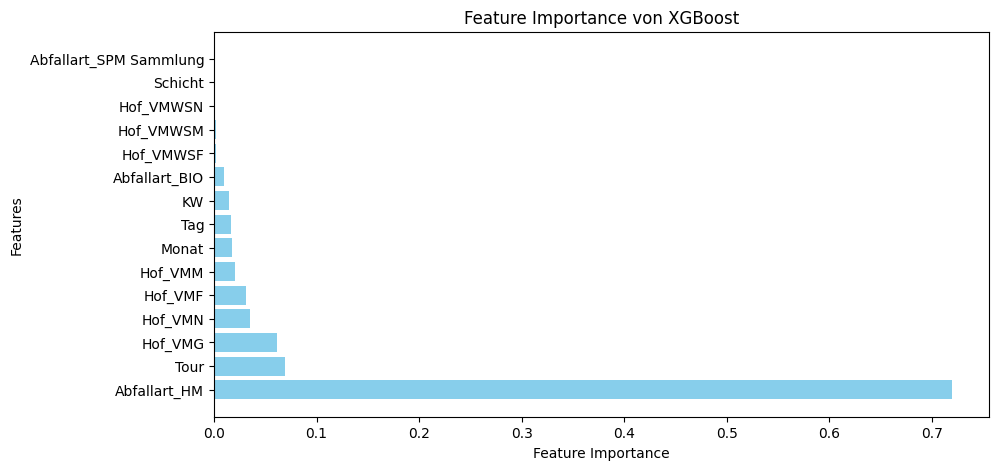

In [37]:
import matplotlib.pyplot as plt

# Stelle sicher, dass wir nur die Spalten verwenden, die beim Training genutzt wurden
X_train_filtered = X_train.drop(columns=['Jahr'])

# DataFrame mit Features + Importances erstellen
df_importance = pd.DataFrame({
    'Feature': X_train_filtered.columns,  # Hier NICHT X_train verwenden!
    'Importance': model.feature_importances_
})

# Sortieren nach Wichtigkeit
df_importance = df_importance.sort_values(by='Importance', ascending=False)
print(df_importance)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(df_importance["Feature"], df_importance["Importance"], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance von XGBoost")
plt.show()



**unwichtige Features entfernen**

In [38]:
features_to_drop = ["Abfallart_SPM Sammlung", "Schicht", "Hof_VMWSF", "Hof_VMWSM", "Hof_VMWSN"]

X_train_reduced = X_train_filtered.drop(columns=features_to_drop)
X_val_reduced = X_val.drop(columns=features_to_drop)

X_val_filtered = X_val_reduced.drop(columns=['Jahr'])

# Modell erneut trainieren
model.fit(X_train_reduced, y_train)

# Neue Evaluation
y_pred_val = model.predict(X_val_filtered)

# Neue Metriken berechnen
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_val, y_pred_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2 = r2_score(y_val, y_pred_val)

print(f"Neuer MAE: {mae:.4f}")
print(f"Neuer RMSE: {rmse:.4f}")
print(f"Neuer R²-Score: {r2:.4f}")


Neuer MAE: 3.2617
Neuer RMSE: 4.1769
Neuer R²-Score: 0.4866


**--> keine Verbesserung des Modelles durch entfernen der Features - sogar eher Verschlechterung**

### Hyperparameter-Tuning

Da das Weglassen der "unwichtigen" Features keine Verbesserung, sondern sogar eher eine Verschlechertung des Modells gebracht hat, wird das Hyperparameter Tuning mit allen vorhandenen Features durchgeführt

In [40]:
df = pd.read_csv(file_path) 
df.head(2)

,Monat,KW,Jahr,Schicht,Tour,Tonnage,Abfallart_BIO,Abfallart_HM,Abfallart_SPM Sammlung,Tag,Hof_VMF,Hof_VMG,Hof_VMM,Hof_VMN,Hof_VMWSF,Hof_VMWSM,Hof_VMWSN
0,1,1,2019,1,1,5.59,1,0,0,2,1,0,0,0,0,0,0
1,1,1,2019,1,4,3.23,1,0,0,2,1,0,0,0,0,0,0


In [41]:
X = df.drop(columns=['Tonnage'])  # Features (alle Spalten außer Ziel)
y = df['Tonnage']  # Zielvariable

In [42]:
# Trainingsdaten: 2019, 2020, 2021
X_train = X[X["Jahr"].isin([2019, 2020, 2021])]
y_train = y[X["Jahr"].isin([2019, 2020, 2021])]

# Validierungsdaten: 2022
X_val = X[X["Jahr"] == 2022]
y_val = y[X["Jahr"] == 2022]

# Testdaten: 2023
X_test = X[X["Jahr"] == 2023]
y_test = y[X["Jahr"] == 2023]

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}, ")

Train: (223715, 16), Validation: (79232, 16), Test: (78714, 16), 


**PARAMETER:**  
**n_estimators** Anzahl der Bäume im Modell	Mehr Bäume verbessern oft die Leistung, aber zu viele können Überanpassung verursachen. Werte von 100-300 sind ein guter Startpunkt.  
**max_depth** Maximale Tiefe eines Baums	Tiefe Bäume erfassen mehr Muster, können aber auch overfitting verursachen. Werte von 3-7 sind eine gute Balance.  
**learning_rate**	Gewichtung jedes neuen Baums	Ein kleinerer Wert (z. B. 0.01-0.1) macht das Training stabiler, aber langsamer.
subsample	Anteil der Trainingsdaten pro Baum	Reduziert Overfitting, indem jeder Baum nur 70-100% der Daten sieht.  
**colsample_bytree**	Anteil der Features, die pro Baum verwendet werden	Reduziert Overfitting und fördert Vielfalt zwischen den Bäumen (70-100%).  



**Warum genau diese Werte?**

Basierend auf Best Practices  
Werte wie max_depth = 3-7 oder learning_rate = 0.01-0.1 sind Standard in der Praxis.  
Performance vs. Rechenzeit  
Ein zu großer n_estimators-Wert (z. B. 1000) erhöht die Trainingszeit stark.  
max_depth über 10 macht das Modell zu komplex und overfitten.  
Guter Kompromiss zwischen Exploration & Optimierung  
GridSearch testet 27 Kombinationen (3×3×3×3=27), was genug ist, ohne das Training zu verlangsamen.  

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],  # Anzahl der Bäume
    'max_depth': [3, 5, 7],  # Maximale Tiefe der Bäume
    'learning_rate': [0.01, 0.05, 0.1],  # Lernrate
    'subsample': [0.7, 0.8, 1.0],  # Anteil der verwendeten Daten pro Baum
    'colsample_bytree': [0.7, 0.8, 1.0],  # Anteil der Spalten pro Baum
}
 # XGBoost Modell definieren
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# GridSearch mit 5-facher Kreuzvalidierung
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,  
    verbose=1
)

# GridSearch starten (ohne Zeitmessung)
grid_search.fit(X_train, y_train)

# Beste Parameter ausgeben
print("Beste Hyperparameter:", grid_search.best_params_)




Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/blongsch/ikt/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste Hyperparameter: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}


**colsample_bytree: 1.0** -> 100% der Features pro Baum verwendet	Keine Feature-Reduktion → Modell nutzt alle verfügbaren Infos.  
**learning_rate: 0.05**	-> Schrittweite für jeden Baum	Guter Kompromiss zwischen Stabilität & Geschwindigkeit.  
**max_depth: 7** -> Maximale Tiefe eines Entscheidungsbaums	Fängt komplexe Muster ein, aber nicht zu tief für Overfitting.  
**n_estimators: 100** -> Anzahl der Bäume	Nicht zu viele Bäume → schnelleres Training, geringeres Overfitting.  
**subsample:0.7** -> Prozentsatz der verwendeten Trainingsdaten pro Baum Verhindert Overfitting, da jeder Baum nur 70% der Daten sieht.  

-----------------------------
**beste Parameter im Training anwenden**

In [44]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time 

# Beste Hyperparameter aus GridSearchCV
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.05,
    'max_depth': 7,
    'n_estimators': 100,
    'subsample': 0.7
}

# Modell initialisieren mit besten Hyperparametern
final_model = xgb.XGBRegressor(**best_params, objective="reg:squarederror")


start_time = time.time()
# Modell mit Trainingsdaten (2019-2021) trainieren (Jahr wird nicht verwendet)
final_model.fit(X_train.drop(columns=['Jahr']), y_train)
end_time = time.time()

train_time = end_time - start_time
print(f"Trainingszeit: {train_time:.2f} Sekunden")

# Vorhersagen für das Validierungsjahr 2022
y_pred_val = final_model.predict(X_val.drop(columns=['Jahr']))

# Metriken berechnen
mae = mean_absolute_error(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)
r2 = r2_score(y_val, y_pred_val)

# Ergebnisse ausgeben
print(f"Neuer MAE nach Tuning: {mae:.4f}")
print(f"Neuer RMSE nach Tuning: {rmse:.4f}")
print(f"Neuer R²-Score nach Tuning: {r2:.4f}")


Trainingszeit: 0.52 Sekunden
Neuer MAE nach Tuning: 3.3150
Neuer RMSE nach Tuning: 4.1136
Neuer R²-Score nach Tuning: 0.5021


/Users/blongsch/ikt/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE ist leicht gestiegen (von 3.2580 auf 3.3150): Dies bedeutet, dass die durchschnittliche absolute Abweichung der Vorhersagen etwas größer geworden ist.

RMSE ist gesunken (von 4.1583 auf 4.1136): Da RMSE größere Fehler stärker bestraft, zeigt dieser Rückgang, dass das Modell weniger große Fehler macht.

R²-Score ist gestiegen (von 0.4912 auf 0.5021): Dies bedeutet, dass das Modell nun etwas besser die Varianz der Zielvariable erklärt.

**Interpretation:**
Das Tuning hat dazu geführt, dass das Modell insgesamt stabiler wurde (geringere große Fehler, was am gesunkenen RMSE erkennbar ist).
Die Verbesserung des R²-Scores zeigt, dass das Modell nun etwas mehr der tatsächlichen Variabilität in den Daten erklärt.
Dass MAE leicht gestiegen ist, könnte darauf hindeuten, dass das Modell möglicherweise konservativer geworden ist oder dass kleinere Fehler häufiger sind.

-------------
**auf Testdaten anwenden**

In [45]:
X_test_reduced = X_test.drop(columns=['Jahr'])

# Vorhersage auf den Testdaten
y_pred_test = final_model.predict(X_test_reduced)

# Metriken berechnen
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

# Ergebnisse ausgeben
print(f"MAE auf Testdaten: {mae_test:.4f}")
print(f"RMSE auf Testdaten: {rmse_test:.4f}")
print(f"R²-Score auf Testdaten: {r2_test:.4f}")


MAE auf Testdaten: 3.5523
RMSE auf Testdaten: 4.3353
R²-Score auf Testdaten: 0.2885
